# Dowloading and preparing the Dataset



In [ ]:
#uploading kaggle.json file to download data
from google.colab import files 
files.upload()

In [ ]:
#Installing gpu for faster training
#Ensure GPU is selected in Runtime 

!pip install tensorflow-gpu

In [4]:
!mv kaggle.json /root/.kaggle

In [5]:
import kaggle 
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:47<00:00, 24.6MB/s]
100% 1.06G/1.06G [00:47<00:00, 24.0MB/s]


In [ ]:
# !unzip dogs-vs-cats
!unzip dogs-vs-cats

#The Model Part

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.applications import ResNet50



In [ ]:
# #Preparing Data
# from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255)
# train_data_gen =  train_datagen.flow_from_directory(
#     './PetImages',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary')

In [13]:
#preparing the base convolution
conv_base = ResNet50(weights='imagenet',
                     include_top = False,
                     input_shape= (224,224,3))

94765736/94765736 [==============================] - 5s 0us/step


In [14]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
#Preparing the model
model = Sequential() 
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 74,915,841
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
#Freezing the convolutional Layers
conv_base.trainable = False

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 51,381,249
Non-trainable params: 23,587,712
_________________________________________________________________


#Preparing the Dataset

In [19]:
#Generators 
train_dataset = tf.keras.utils.image_dataset_from_directory(
    './dogs_vs_cats/train',
    labels= 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (224, 224)
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    './dogs_vs_cats/test',
    labels= 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (224, 224)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [20]:
#Normalize 
def process(image, label):
  # channels = tf.shape(image)[-1]
  # # if channels < 3:
  # #    image = tf.image.grayscale_to_rgb(image)

  image = tf.cast(image/255., tf.float32)
  return image, label

train_set = train_dataset.map(process)
val_set = val_dataset.map(process)

In [21]:
#compiling the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
#Training the Data, training with gpu
with tf.device('/device:GPU:0'):
  history = model.fit(train_set, epochs =5 , validation_data = val_set)

Epoch 1/5
625/625 [==============================] - 104s 141ms/step - loss: 0.9683 - accuracy: 0.6107 - val_loss: 0.5885 - val_accuracy: 0.6962
Epoch 2/5
625/625 [==============================] - 87s 139ms/step - loss: 0.6002 - accuracy: 0.6733 - val_loss: 0.5818 - val_accuracy: 0.6986
Epoch 3/5
625/625 [==============================] - 81s 129ms/step - loss: 0.5802 - accuracy: 0.6955 - val_loss: 0.6008 - val_accuracy: 0.6666
Epoch 4/5
625/625 [==============================] - 82s 131ms/step - loss: 0.5574 - accuracy: 0.7117 - val_loss: 0.5692 - val_accuracy: 0.7070
Epoch 5/5
625/625 [==============================] - 81s 129ms/step - loss: 0.5409 - accuracy: 0.7218 - val_loss: 0.6257 - val_accuracy: 0.6506


#Ploting the performance of the Mode

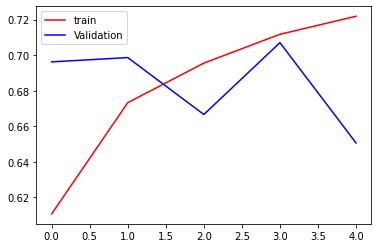

In [24]:
#Plotting Accuracy
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'], color= 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation')
plt.legend()
plt.show()

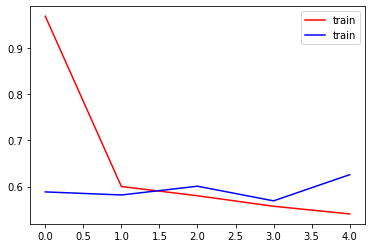

In [25]:
#Plotting Loss
plt.plot(history.history['loss'], color= 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'train')
plt.legend()
plt.show()


In [ ]:
#Saving the Model 
model.save('cat-dog-resnet50.h5')